In [1]:
import argparse
import os
import random
import scipy as sp
import pickle

import shutil
import csv
import ast

import scipy.sparse as sparse
from tqdm import tqdm
from torch import Tensor
import networkx as nx
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
from torch_geometric.data import Data

import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from autoencoder import VariationalAutoEncoder, VariationalAutoEncoderWithInfoNCE
from denoise_model import DenoiseNN, p_losses, sample
from utils import linear_beta_schedule, construct_nx_from_adj, preprocess_dataset, subgraph_augment, edge_drop, \
    preprocess_dataset_with_pretrained_embedder

from torch.utils.data import Subset


2025-01-08 09:44:31.324187: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 09:44:31.325533: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 09:44:31.343167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 09:44:31.343183: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 09:44:31.343197: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_max_nodes=50
spectral_emb_dim=10
preprocess_function = preprocess_dataset
# preprocess train data, validation data and test data. Only once for the first time that you run the code. Then the appropriate .pt files will be saved and loaded.
trainset = preprocess_function("train", n_max_nodes, spectral_emb_dim)
validset = preprocess_function("valid", n_max_nodes, spectral_emb_dim)
testset = preprocess_function("test", n_max_nodes, spectral_emb_dim)

/home/antoine/Bureau/3A/altegrad/Conditional-Graph-Generation/src/utils.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_lst = torch.load(filename)


Dataset ./data/dataset_train.pt loaded from file
Dataset ./data/dataset_valid.pt loaded from file
Dataset ./data/dataset_test.pt loaded from file


/home/antoine/Bureau/3A/altegrad/Conditional-Graph-Generation/src/utils.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_lst = torch.load(filename)


In [3]:
from extract_data import STATS

data = trainset[0]
print(data.keys())
print(data.num_nodes)
print(list(zip(STATS, data.stats[0])))

['x', 'filename', 'A', 'edge_index', 'stats']
44
[('node', tensor(44.)), ('edge', tensor(406.)), ('degre', tensor(18.4545)), ('triangles', tensor(1049.)), ('g_cluster_coef', tensor(0.4315)), ('max_k_core', tensor(14.)), ('communities', tensor(4.))]


HAAA
[tensor(26, dtype=torch.int32), tensor(13.), tensor(1.), tensor(0.), tensor(nan), 1, 13]
HAAA
[tensor(32, dtype=torch.int32), tensor(16.), tensor(1.), tensor(0.), tensor(nan), 1, 16]
HAAA
[tensor(22, dtype=torch.int32), tensor(11.), tensor(1.), tensor(0.), tensor(nan), 1, 11]
HAAA
[tensor(10, dtype=torch.int32), tensor(5.), tensor(1.), tensor(0.), tensor(nan), 1, 5]
HAAA
[tensor(14, dtype=torch.int32), tensor(7.), tensor(1.), tensor(0.), tensor(nan), 1, 7]
HAAA
[tensor(18, dtype=torch.int32), tensor(9.), tensor(1.), tensor(0.), tensor(nan), 1, 9]
HAAA
[tensor(22, dtype=torch.int32), tensor(11.), tensor(1.), tensor(0.), tensor(nan), 1, 11]
HAAA
[tensor(16, dtype=torch.int32), tensor(8.), tensor(1.), tensor(0.), tensor(nan), 1, 8]
HAAA
[tensor(18, dtype=torch.int32), tensor(9.), tensor(1.), tensor(0.), tensor(nan), 1, 9]
HAAA
[tensor(26, dtype=torch.int32), tensor(13.), tensor(1.), tensor(0.), tensor(nan), 1, 13]
HAAA
[tensor(16, dtype=torch.int32), tensor(8.), tensor(1.), tensor(0.

tensor(nan)

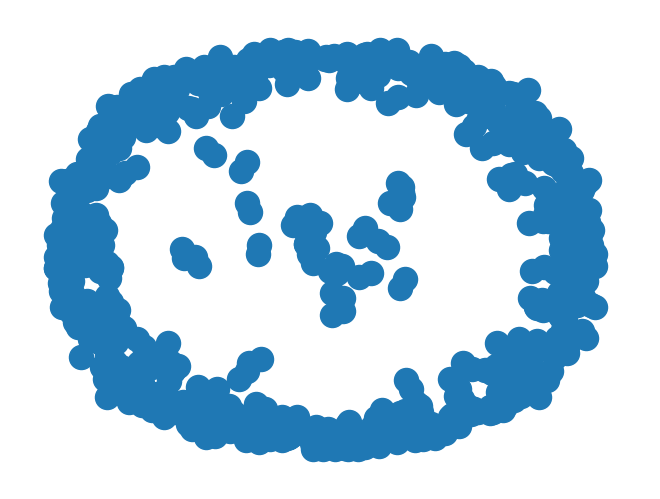

In [8]:
import torch

# Assuming you have imported these functions already
from extract_data import create_features, compute_MAE
from graph_utils import edge_index_to_dense

stats_true = []
num_nodes_batched = []
adj_matrices = []

# Step 1: Collect the adjacency matrices and stats
for data in trainset:
    adj_matrices.append(edge_index_to_dense(data.edge_index, data.num_nodes))
    num_nodes_batched.append(data.num_nodes)
    stats_true.append(data.stats[0])

# Step 2: Find the maximum number of nodes in the batch
max_num_nodes = max(num_nodes_batched)

# Step 3: Pad the adjacency matrices to max_num_nodes
padded_adj_matrices = []
for adj_matrix, num_nodes in zip(adj_matrices, num_nodes_batched):
    # Padding the matrix to the shape of (max_num_nodes, max_num_nodes)
    padded_matrix = torch.zeros((max_num_nodes, max_num_nodes), dtype=adj_matrix.dtype)
    padded_matrix[:num_nodes, :num_nodes] = adj_matrix
    padded_adj_matrices.append(padded_matrix)

# Step 4: Stack the padded adjacency matrices and stats
adj_matrices_padded = torch.stack(padded_adj_matrices, dim=0)
stats_true_tensor = torch.stack(stats_true, dim=0)

# Step 5: Compute MAE
compute_MAE(adj_matrices_padded, torch.Tensor(num_nodes_batched).int(), stats_true_tensor)


In [5]:
data_weird = validset[77]

In [6]:
create_features(edge_index_to_dense(data.edge_index, data.num_nodes), data.num_nodes)

tensor([ 37.0000, 154.0000,   8.3243, 175.0000,   0.3465,   5.0000,   4.0000])

47
tensor([[ 0,  0,  0,  1,  1,  2,  2,  2,  3,  3,  4,  5,  5,  6,  7,  8,  8,  9,
          9,  9, 10, 10, 10, 11, 12, 12, 12, 13, 14, 14, 14, 15, 16, 16, 16, 17,
         17, 18, 18, 18, 19, 19, 20, 21, 21, 21, 22, 22, 23, 24, 24, 24, 25, 26,
         27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 32, 32, 33, 34, 34, 34, 35,
         35, 36, 36, 37, 37, 38, 39, 39, 39, 40, 41, 41, 41, 42, 42, 43, 43, 44,
         45, 46],
        [ 1,  2,  3,  0,  4,  0,  5,  6,  0,  7,  1,  2,  8,  2,  3,  5,  9,  8,
         10, 11,  9, 12, 13,  9, 10, 14, 15, 10, 12, 16, 17, 12, 14, 18, 19, 14,
         20, 16, 21, 22, 16, 23, 17, 18, 24, 25, 18, 26, 19, 21, 27, 28, 21, 22,
         24, 29, 24, 27, 30, 31, 29, 32, 33, 29, 30, 34, 35, 30, 32, 36, 37, 32,
         38, 34, 39, 34, 40, 35, 36, 41, 42, 37, 39, 43, 44, 39, 45, 41, 46, 41,
         42, 43]])
tensor([3., 2., 3., 2., 1., 2., 1., 1., 2., 3., 3., 1., 3., 1., 3., 1., 3., 2.,
        3., 2., 1., 3., 2., 1., 3., 1., 1., 2., 1., 3., 3., 1., 3., 1.

KeyboardInterrupt: Interrupted by user

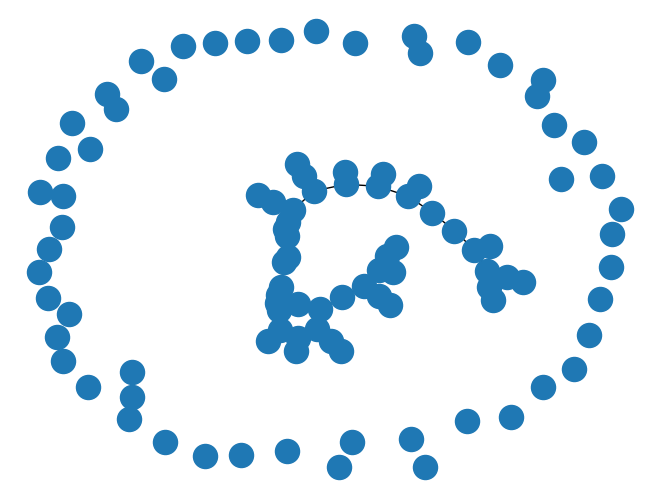

In [30]:
for data in trainset:
    adj = edge_index_to_dense(data.edge_index, 100)
    if data.num_nodes != (adj.sum(dim=1)>=1).sum():
        print(data.num_nodes - (edge_index_to_dense(data.edge_index, data.num_nodes).sum(dim=1)>=1).sum())
    if adj.sum() /2 < data.num_nodes:
        print(data.num_nodes)
        print(data.edge_index)
        print(adj.sum(dim=1))
        print(adj[30])
        print((adj.sum(dim=1)>=1).sum() )
        nx.draw(nx.from_numpy_array(adj.cpu().numpy()))
        input("go on ?")
    